In [233]:
import os
import glob
import pickle
import importlib


import numpy as np
import pandas as pd
plt.style.use('seaborn-poster')

import utils
importlib.reload(utils)

import plotting_utils
importlib.reload(plotting_utils)

<module 'plotting_utils' from '/Users/qingkaikong/Desktop/USGS/notebooks/plotting_utils.py'>

In [329]:
data_path = '../data/myshake_data/20200101_20200801/'
df_epic = pd.read_hdf('../data/e2trigs_20200101_20200825.h5')

In [315]:
#df_e2event = pd.read_hdf('../data/e2event_20160201_20200923.h5')
df_dmreview = pd.read_hdf('../data/dmreview_20160201_20190929.h5')
df_event = pd.read_hdf('../data/event_20160201_20190929.h5')

In [330]:
DEBUG = False
results = [] 
for f_hb in glob.glob(os.path.join(data_path, '*_heartbeat.pkl')):
    
    evid = f_hb.split('/')[-1].split('_')[0]
    
    #if os.path.isfile('../figures/' + evid + '.png'):
    #    continue
    
    if DEBUG:
        output_folder = None
        if evid != 'nc72672610':
            continue
        
    # read in the data
    df_heartbeat = pd.read_pickle(f_hb)
    df_trig = pd.read_pickle(f_hb.replace('_heartbeat', '_trig'))
    earthquake = pd.read_pickle(f_hb.replace('_heartbeat', '_ground_truth'))
    
    # read in the simulation data
    simulation_file = glob.glob(os.path.join(data_path, evid + '*_simulations.pkl'))[0]
    simulation_dict = pickle.load(open(simulation_file, 'rb'))
    
    orig_time, t_start, t_end = \
        utils.slice_time_from_eq_origin(
                earthquake,
                start_time_s_from_origin=-30,
                end_time_s_from_origin=60
                                       )
    
    # select the e2created events from origin of the EQ to the end
    df_event_select = df_event[t_start:t_end]
    df_event_select = df_event_select[df_event_select['system']=='dm']
    df_event_select = df_event_select.assign(tt_rel= df_event_select['alert_time'] - orig_time)
    
    # only get the new created events
    df_event_select = df_event_select[df_event_select['type']=='new']
    
    if len(df_event_select) < 1:
        print(f'No ShakeAlert alert for {evid}')
        continue
    
    # get the first alert
    first_alert = df_event_select.iloc[0]
    n_sa_station = first_alert['nsta']
    
    # get number of triggers before the first alert
    df_trig, _, _, df_stalta_trig, _, df_epic_select = \
        utils.prepare_myshake_data(earthquake,
                                   orig_time,
                                   df_trig,
                                   df_heartbeat,
                                   df_epic,
                                   t_start,
                                   t_end,
                                   max_dist_km=300,
                                   myshake_legacy=False,
                                     )
    
    count_1st_alert = get_count_stats(df_trig,
                                      df_stalta_trig,
                                      df_epic_select,
                                      simulation_dict,
                                      first_alert['tt_rel'],
                                      earthquake)
    
    
    # get the number of triggers before the first trigger
    if count_1st_alert['n_dm_sta'] != first_alert['nsta']:
        print(f"{evid}, there are "
              f"{count_1st_alert['n_dm_sta']} in the trigger, "
              f"but {first_alert['nsta']} in DM event table!")
        
    count_1st_trig = get_count_stats(df_trig,
                                     df_stalta_trig,
                                     count_1st_alert['dm_sta'],
                                     simulation_dict,
                                     count_1st_alert['dm_sta']['tt_rel'].min(),
                                     earthquake)
        
    
    # get the number of triggers before the median trigger df_epic_1st_alert['tt_rel'].median()
    # this is when half of the total triggers of all the triggers before the alerting time
    count_half_trig = get_count_stats(df_trig,
                                     df_stalta_trig,
                                     count_1st_alert['dm_sta'],
                                     simulation_dict,
                                     count_1st_alert['dm_sta']['tt_rel'].median(),
                                     earthquake)
    
    # get the number of triggers before the median trigger df_epic_1st_alert['tt_rel'].median()
    # this is when half of the total triggers of all the triggers before the alerting time
    count_half_alert = get_count_stats(df_trig,
                                     df_stalta_trig,
                                     count_1st_alert['dm_sta'],
                                     simulation_dict,
                                     first_alert['tt_rel']/2.0,
                                     earthquake)
    
    results.append([evid, earthquake['time'], orig_time, earthquake['latitude'],
                    earthquake['longitude'], earthquake['mag'], earthquake['depth'],
                    earthquake['place'], first_alert['alert_time'], first_alert['tt_rel'],
                    first_alert['mag'], first_alert['lat'], first_alert['lon'],
                    first_alert['depth'],first_alert['nsta'], first_alert['nalg'],
                    count_1st_alert['n_myshake_stalta'], count_1st_alert['n_myshake_ann'], 
                    count_1st_trig['n_myshake_stalta'], count_1st_trig['n_myshake_ann'],
                    count_half_trig['n_myshake_stalta'], count_half_trig['n_myshake_ann'],
                    count_half_alert['n_myshake_stalta'], count_half_alert['n_myshake_ann'],
                    count_1st_alert['steady_phone_stats_syn']['mu'], 
                    count_1st_alert['steady_phone_stats_syn']['median'],
                    count_1st_alert['steady_phone_stats_syn']['std'], 
                    count_1st_alert['trig_stats_syn']['mu'],
                    count_1st_alert['trig_stats_syn']['median'], 
                    count_1st_alert['trig_stats_syn']['std'],
                    count_1st_trig['steady_phone_stats_syn']['mu'], 
                    count_1st_trig['steady_phone_stats_syn']['median'],
                    count_1st_trig['steady_phone_stats_syn']['std'], 
                    count_1st_trig['trig_stats_syn']['mu'],
                    count_1st_trig['trig_stats_syn']['median'], 
                    count_1st_trig['trig_stats_syn']['std'],
                    count_half_trig['steady_phone_stats_syn']['mu'], 
                    count_half_trig['steady_phone_stats_syn']['median'],
                    count_half_trig['steady_phone_stats_syn']['std'], 
                    count_half_trig['trig_stats_syn']['mu'],
                    count_half_trig['trig_stats_syn']['median'], 
                    count_half_trig['trig_stats_syn']['std'],
                    count_half_alert['steady_phone_stats_syn']['mu'], 
                    count_half_alert['steady_phone_stats_syn']['median'],
                    count_half_alert['steady_phone_stats_syn']['std'], 
                    count_half_alert['trig_stats_syn']['mu'],
                    count_half_alert['trig_stats_syn']['median'], 
                    count_half_alert['trig_stats_syn']['std']
                    ])

columns = ['evid', 'evtime', 'orig_time', 'evla', 'evlo', 'mag', 'depth',
           'place', 'alert_time', 'alert_time_rel', 'est_mag', 'est_evla',
           'est_evlo', 'est_depth', 'nsta', 'nalg', 'n_stalta_1st_alert',
           'n_ann_1st_alert', 'n_stalta_1st_trig', 'n_ann_1st_trig',
           'n_steady_phone_syn_mu_1st_alert','n_steady_phone_syn_median_1st_alert',
           'n_steady_phone_syn_std_1st_alert','n_trig_syn_mu_1st_alert',
           'n_trig_syn_median_1st_alert','n_trig_syn_std_1st_alert',
           'n_trig_syn_median_half_trig','n_trig_syn_std_half_trig',
           'n_trig_syn_median_half_alert','n_trig_syn_std_half_alert',
           'n_steady_phone_syn_mu_1st_trig','n_steady_phone_syn_median_1st_trig',
           'n_steady_phone_syn_std_1st_trig','n_trig_syn_mu_1st_trig',
           'n_trig_syn_median_1st_trig','n_trig_syn_std_1st_trig',
           'n_steady_phone_syn_mu_half_trig','n_steady_phone_syn_median_half_trig',
           'n_steady_phone_syn_std_half_trig','n_trig_syn_mu_half_trig',
           'n_trig_syn_median_half_trig','n_trig_syn_std_half_trig',
           'n_steady_phone_syn_mu_half_alert','n_steady_phone_syn_median_half_alert',
           'n_steady_phone_syn_std_half_alert','n_trig_syn_mu_half_alert',
           'n_trig_syn_median_half_alert','n_trig_syn_std_half_alert'] 
df_results = pd.DataFrame(results, columns=columns)

ci39462920, there are 9 in the trigger, but 5 in DM event table!
ci38488354, there are 8 in the trigger, but 4 in DM event table!
ci39494120, there are 8 in the trigger, but 4 in DM event table!
No ShakeAlert alert for nc73371960
ci39491208, there are 7 in the trigger, but 5 in DM event table!
nc73374265, there are 13 in the trigger, but 11 in DM event table!
nc73340375, there are 11 in the trigger, but 5 in DM event table!
nc73367635, there are 4 in the trigger, but 6 in DM event table!
ci39464360, there are 14 in the trigger, but 9 in DM event table!
nc73368095, there are 12 in the trigger, but 11 in DM event table!
ci39214247, there are 9 in the trigger, but 4 in DM event table!
ci38603762, there are 8 in the trigger, but 4 in DM event table!
nc73399446, there are 16 in the trigger, but 14 in DM event table!
ci39208391, there are 16 in the trigger, but 12 in DM event table!
No ShakeAlert alert for nc73367590
No ShakeAlert alert for nc73351710
nc73355700, there are 9 in the trigger, 

In [331]:
df_results.to_csv('count_stats_2020.csv', index=False)

In [278]:
def get_count_stats(df_trig,
                    df_stalta_trig,
                    df_epic_select,
                    simulation_dict,
                    count_time,
                    earthquake):
    count_stats = {}
    df_trig, df_stalta, df_epic = \
        get_data_before_time(
            df_trig,
            df_stalta_trig,
            df_epic_select,
            count_time)
    
    ### for simulation
    steady_phone_stats_syn, trig_stats_syn = simulation_data_count(
        simulation_dict,
        count_time,
        earthquake)
    
    count_stats['n_myshake_ann'] = len(df_trig)
    count_stats['n_myshake_stalta'] = len(df_stalta)
    count_stats['n_dm_sta'] = len(df_epic)
    
    count_stats['myshake_ann'] = df_trig
    count_stats['myshake_stalta'] = df_stalta
    count_stats['dm_sta'] = df_epic
    
    count_stats['steady_phone_stats_syn'] = steady_phone_stats_syn
    count_stats['trig_stats_syn'] = trig_stats_syn
    
    return count_stats

In [210]:
def get_stats(data):
    mu = np.mean(data)
    median = np.median(data)
    std = np.std(data)
    
    results = {'mu':mu,
               'median':median,
               'std':std}
    return results


def simulation_data_count(simulation_dict,
                          alert_time,
                          earthquake):
    
    p_wave_distance_at_alert_time = alert_time * 6.10
    
    steady_phone_list = []
    trig_list = []
    for key, simulation in simulation_dict.items():
        count = 0
        steady_phone = simulation['phones_steady']
        for stla, stlo in steady_phone:
            dist = calculate_dist(earthquake['latitude'],
                       earthquake['longitude'],
                       stla,
                       stlo)
            if dist <= p_wave_distance_at_alert_time:
                count += 1
                
        steady_phone_list.append(count)
        
        df = select_data_between_time_and_space(
            simulation['df_trig'],
            t_start=0,
            t_end=alert_time,
            max_dist_km=p_wave_distance_at_alert_time)
        trig_list.append(len(df))
    
    steady_phone_stats = get_stats(steady_phone_list)
    trig_stats = get_stats(trig_list)
    
    
    return steady_phone_stats, trig_stats

({'mu': 13.0, 'median': 12.0, 'std': 3.9496835316262997},
 {'mu': 0.0, 'median': 0.0, 'std': 0.0})

In [197]:
def get_data_before_time(df_trig,
                         df_stalta_trig,
                         df_epic,
                         alert_time,
                         ):
    
    p_wave_distance_at_alert_time = alert_time * 6.10
    
    df_trig_select = select_data_between_time_and_space(
        df_trig,
        t_start=0,
        t_end=alert_time,
        max_dist_km=p_wave_distance_at_alert_time)

    df_stalta_select = select_data_between_time_and_space(
        df_stalta_trig,
        t_start=0,
        t_end=alert_time,
        max_dist_km=p_wave_distance_at_alert_time)

    df_epic_select = select_data_between_time_and_space(
        df_epic,
        t_start=0,
        t_end=alert_time,
        max_dist_km=p_wave_distance_at_alert_time)
    
    return df_trig_select, df_stalta_select, df_epic_select.drop_duplicates('sta')

def select_data_between_time_and_space(df,
                                       t_start=0,
                                       t_end=60,
                                       max_dist_km=300):
    df = df[
        df['dist_km'] < max_dist_km]
    df = df[
        (df['tt_rel'] <= t_end) &
        (df['tt_rel'] > 0 )]
    return df

/Users/qingkaikong/Desktop/USGS/notebooks/plotting_utils.py:268: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


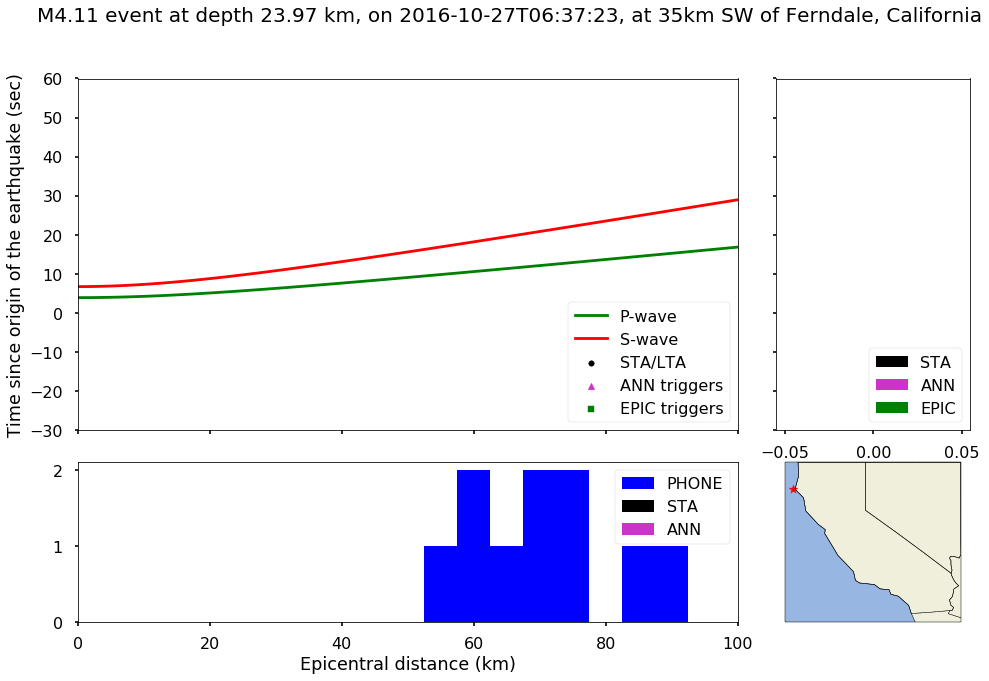

In [234]:
plotting_utils.plot_comparison_plot(df_trig,
                                    df_heartbeat,
                                    df_epic,
                                    df_event,
                                    earthquake, 
                                    save_folder=None, 
                                    myshake_legacy=True,
                                    plot_simulation=False,
                                    simulation_path=None,
                                    include_dm_alert_updates=False)

In [100]:
df_event = pd.read_hdf('../data/event.h5')
df_event_old = pd.read_hdf('../data/event_old.h5')

In [104]:
df_combine = pd.concat([df_event, df_event_old])

In [105]:
df_combine['datetime'] = pd.to_datetime(df_combine['alert_time'],unit='s')

# set index
df_combine = df_combine.set_index('datetime')
df_combine = df_combine.sort_index()

df_combine.to_hdf('./event_20160201_20190929.h5', 'event')